In [218]:
import argparse
import os
from collections import OrderedDict
from time import time

import torch
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support, plot_precision_recall_curve, precision_score, recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

from genEM3.model.VAE import ConvVAE
from genEM3.data.wkwdata import WkwData, DataSplit
from genEM3.util import path
from genEM3.training.VAE import generate_dir_prefix, predict

In [3]:
# set the proper device (GPU with a specific ID or cpu)
cuda = False
gpu_id = 0
if cuda:
    print(f'Using GPU: {gpu_id}')
    gpu.get_gpu(gpu_id)
    device = torch.device(torch.cuda.current_device())
else:
    device = torch.device("cpu")

In [4]:
# Get model dir
model_dir = os.path.join(path.get_conndata_dir_AK(), 
                         ''.join([generate_dir_prefix(max_weight_kld=1.0, warmup_bool=True),'GABAG04-03_Oct_2020-17_06_57']),
                        '.log/model_best.pth')
print(model_dir)

/conndata/alik/genEM3_runs/VAE/weightedVAE_1.0_warmup_True_GABAG04-03_Oct_2020-17_06_57/.log/model_best.pth


In [5]:
# Load model
input_size = 140
output_size = 140
kernel_size = 3
stride = 1
model = ConvVAE.from_saved_state_dict(model_dir=model_dir,
                              latent_size=2048,
                              input_size=input_size,
                              output_size=output_size,
                              kernel_size=kernel_size,
                              stride=stride,
                              weight_KLD=1.0)

In [6]:
# Load the training data
cache_HDD_root = os.path.join(path.get_conndata_dir_AK(), '.cache/')
datasources_json_path = os.path.join(path.getDataDir(), 'debris_clean_added_bboxes2_wiggle_datasource.json')
input_shape = (140, 140, 1)
output_shape = (140, 140, 1)

data_split = DataSplit(train=0.85, validation=0.15, test=0.00)
cache_RAM = True
cache_HDD = True
batch_size = 256
num_workers = 12

data_sources = WkwData.datasources_from_json(datasources_json_path)

dataset = WkwData(
    input_shape=input_shape,
    target_shape=output_shape,
    data_sources=data_sources,
    data_split=data_split,
    cache_RAM=cache_RAM,
    cache_HDD=cache_HDD,
    cache_HDD_root=cache_HDD_root
)

Filling caches ... data source 1/3036 input
Filling caches ... data source 1/3036 target
Filling caches ... data source 2/3036 input
Filling caches ... data source 2/3036 target
Filling caches ... data source 3/3036 input
Filling caches ... data source 3/3036 target
Filling caches ... data source 4/3036 input
Filling caches ... data source 4/3036 target
Filling caches ... data source 5/3036 input
Filling caches ... data source 5/3036 target
Filling caches ... data source 6/3036 input
Filling caches ... data source 6/3036 target
Filling caches ... data source 7/3036 input
Filling caches ... data source 7/3036 target
Filling caches ... data source 8/3036 input
Filling caches ... data source 8/3036 target
Filling caches ... data source 9/3036 input
Filling caches ... data source 9/3036 target
Filling caches ... data source 10/3036 input
Filling caches ... data source 10/3036 target
Filling caches ... data source 11/3036 input
Filling caches ... data source 11/3036 target
Filling caches ..

Filling caches ... data source 93/3036 target
Filling caches ... data source 94/3036 input
Filling caches ... data source 94/3036 target
Filling caches ... data source 95/3036 input
Filling caches ... data source 95/3036 target
Filling caches ... data source 96/3036 input
Filling caches ... data source 96/3036 target
Filling caches ... data source 97/3036 input
Filling caches ... data source 97/3036 target
Filling caches ... data source 98/3036 input
Filling caches ... data source 98/3036 target
Filling caches ... data source 99/3036 input
Filling caches ... data source 99/3036 target
Filling caches ... data source 100/3036 input
Filling caches ... data source 100/3036 target
Filling caches ... data source 101/3036 input
Filling caches ... data source 101/3036 target
Filling caches ... data source 102/3036 input
Filling caches ... data source 102/3036 target
Filling caches ... data source 103/3036 input
Filling caches ... data source 103/3036 target
Filling caches ... data source 104/3

Filling caches ... data source 184/3036 target
Filling caches ... data source 185/3036 input
Filling caches ... data source 185/3036 target
Filling caches ... data source 186/3036 input
Filling caches ... data source 186/3036 target
Filling caches ... data source 187/3036 input
Filling caches ... data source 187/3036 target
Filling caches ... data source 188/3036 input
Filling caches ... data source 188/3036 target
Filling caches ... data source 189/3036 input
Filling caches ... data source 189/3036 target
Filling caches ... data source 190/3036 input
Filling caches ... data source 190/3036 target
Filling caches ... data source 191/3036 input
Filling caches ... data source 191/3036 target
Filling caches ... data source 192/3036 input
Filling caches ... data source 192/3036 target
Filling caches ... data source 193/3036 input
Filling caches ... data source 193/3036 target
Filling caches ... data source 194/3036 input
Filling caches ... data source 194/3036 target
Filling caches ... data

Filling caches ... data source 289/3036 target
Filling caches ... data source 290/3036 input
Filling caches ... data source 290/3036 target
Filling caches ... data source 291/3036 input
Filling caches ... data source 291/3036 target
Filling caches ... data source 292/3036 input
Filling caches ... data source 292/3036 target
Filling caches ... data source 293/3036 input
Filling caches ... data source 293/3036 target
Filling caches ... data source 294/3036 input
Filling caches ... data source 294/3036 target
Filling caches ... data source 295/3036 input
Filling caches ... data source 295/3036 target
Filling caches ... data source 296/3036 input
Filling caches ... data source 296/3036 target
Filling caches ... data source 297/3036 input
Filling caches ... data source 297/3036 target
Filling caches ... data source 298/3036 input
Filling caches ... data source 298/3036 target
Filling caches ... data source 299/3036 input
Filling caches ... data source 299/3036 target
Filling caches ... data

Filling caches ... data source 383/3036 target
Filling caches ... data source 384/3036 input
Filling caches ... data source 384/3036 target
Filling caches ... data source 385/3036 input
Filling caches ... data source 385/3036 target
Filling caches ... data source 386/3036 input
Filling caches ... data source 386/3036 target
Filling caches ... data source 387/3036 input
Filling caches ... data source 387/3036 target
Filling caches ... data source 388/3036 input
Filling caches ... data source 388/3036 target
Filling caches ... data source 389/3036 input
Filling caches ... data source 389/3036 target
Filling caches ... data source 390/3036 input
Filling caches ... data source 390/3036 target
Filling caches ... data source 391/3036 input
Filling caches ... data source 391/3036 target
Filling caches ... data source 392/3036 input
Filling caches ... data source 392/3036 target
Filling caches ... data source 393/3036 input
Filling caches ... data source 393/3036 target
Filling caches ... data

Filling caches ... data source 495/3036 input
Filling caches ... data source 495/3036 target
Filling caches ... data source 496/3036 input
Filling caches ... data source 496/3036 target
Filling caches ... data source 497/3036 input
Filling caches ... data source 497/3036 target
Filling caches ... data source 498/3036 input
Filling caches ... data source 498/3036 target
Filling caches ... data source 499/3036 input
Filling caches ... data source 499/3036 target
Filling caches ... data source 500/3036 input
Filling caches ... data source 500/3036 target
Filling caches ... data source 501/3036 input
Filling caches ... data source 501/3036 target
Filling caches ... data source 502/3036 input
Filling caches ... data source 502/3036 target
Filling caches ... data source 503/3036 input
Filling caches ... data source 503/3036 target
Filling caches ... data source 504/3036 input
Filling caches ... data source 504/3036 target
Filling caches ... data source 505/3036 input
Filling caches ... data 

Filling caches ... data source 587/3036 target
Filling caches ... data source 588/3036 input
Filling caches ... data source 588/3036 target
Filling caches ... data source 589/3036 input
Filling caches ... data source 589/3036 target
Filling caches ... data source 590/3036 input
Filling caches ... data source 590/3036 target
Filling caches ... data source 591/3036 input
Filling caches ... data source 591/3036 target
Filling caches ... data source 592/3036 input
Filling caches ... data source 592/3036 target
Filling caches ... data source 593/3036 input
Filling caches ... data source 593/3036 target
Filling caches ... data source 594/3036 input
Filling caches ... data source 594/3036 target
Filling caches ... data source 595/3036 input
Filling caches ... data source 595/3036 target
Filling caches ... data source 596/3036 input
Filling caches ... data source 596/3036 target
Filling caches ... data source 597/3036 input
Filling caches ... data source 597/3036 target
Filling caches ... data

Filling caches ... data source 701/3036 target
Filling caches ... data source 702/3036 input
Filling caches ... data source 702/3036 target
Filling caches ... data source 703/3036 input
Filling caches ... data source 703/3036 target
Filling caches ... data source 704/3036 input
Filling caches ... data source 704/3036 target
Filling caches ... data source 705/3036 input
Filling caches ... data source 705/3036 target
Filling caches ... data source 706/3036 input
Filling caches ... data source 706/3036 target
Filling caches ... data source 707/3036 input
Filling caches ... data source 707/3036 target
Filling caches ... data source 708/3036 input
Filling caches ... data source 708/3036 target
Filling caches ... data source 709/3036 input
Filling caches ... data source 709/3036 target
Filling caches ... data source 710/3036 input
Filling caches ... data source 710/3036 target
Filling caches ... data source 711/3036 input
Filling caches ... data source 711/3036 target
Filling caches ... data

Filling caches ... data source 799/3036 target
Filling caches ... data source 800/3036 input
Filling caches ... data source 800/3036 target
Filling caches ... data source 801/3036 input
Filling caches ... data source 801/3036 target
Filling caches ... data source 802/3036 input
Filling caches ... data source 802/3036 target
Filling caches ... data source 803/3036 input
Filling caches ... data source 803/3036 target
Filling caches ... data source 804/3036 input
Filling caches ... data source 804/3036 target
Filling caches ... data source 805/3036 input
Filling caches ... data source 805/3036 target
Filling caches ... data source 806/3036 input
Filling caches ... data source 806/3036 target
Filling caches ... data source 807/3036 input
Filling caches ... data source 807/3036 target
Filling caches ... data source 808/3036 input
Filling caches ... data source 808/3036 target
Filling caches ... data source 809/3036 input
Filling caches ... data source 809/3036 target
Filling caches ... data

Filling caches ... data source 895/3036 input
Filling caches ... data source 895/3036 target
Filling caches ... data source 896/3036 input
Filling caches ... data source 896/3036 target
Filling caches ... data source 897/3036 input
Filling caches ... data source 897/3036 target
Filling caches ... data source 898/3036 input
Filling caches ... data source 898/3036 target
Filling caches ... data source 899/3036 input
Filling caches ... data source 899/3036 target
Filling caches ... data source 900/3036 input
Filling caches ... data source 900/3036 target
Filling caches ... data source 901/3036 input
Filling caches ... data source 901/3036 target
Filling caches ... data source 902/3036 input
Filling caches ... data source 902/3036 target
Filling caches ... data source 903/3036 input
Filling caches ... data source 903/3036 target
Filling caches ... data source 904/3036 input
Filling caches ... data source 904/3036 target
Filling caches ... data source 905/3036 input
Filling caches ... data 

Filling caches ... data source 995/3036 target
Filling caches ... data source 996/3036 input
Filling caches ... data source 996/3036 target
Filling caches ... data source 997/3036 input
Filling caches ... data source 997/3036 target
Filling caches ... data source 998/3036 input
Filling caches ... data source 998/3036 target
Filling caches ... data source 999/3036 input
Filling caches ... data source 999/3036 target
Filling caches ... data source 1000/3036 input
Filling caches ... data source 1000/3036 target
Filling caches ... data source 1001/3036 input
Filling caches ... data source 1001/3036 target
Filling caches ... data source 1002/3036 input
Filling caches ... data source 1002/3036 target
Filling caches ... data source 1003/3036 input
Filling caches ... data source 1003/3036 target
Filling caches ... data source 1004/3036 input
Filling caches ... data source 1004/3036 target
Filling caches ... data source 1005/3036 input
Filling caches ... data source 1005/3036 target
Filling cac

Filling caches ... data source 1086/3036 target
Filling caches ... data source 1087/3036 input
Filling caches ... data source 1087/3036 target
Filling caches ... data source 1088/3036 input
Filling caches ... data source 1088/3036 target
Filling caches ... data source 1089/3036 input
Filling caches ... data source 1089/3036 target
Filling caches ... data source 1090/3036 input
Filling caches ... data source 1090/3036 target
Filling caches ... data source 1091/3036 input
Filling caches ... data source 1091/3036 target
Filling caches ... data source 1092/3036 input
Filling caches ... data source 1092/3036 target
Filling caches ... data source 1093/3036 input
Filling caches ... data source 1093/3036 target
Filling caches ... data source 1094/3036 input
Filling caches ... data source 1094/3036 target
Filling caches ... data source 1095/3036 input
Filling caches ... data source 1095/3036 target
Filling caches ... data source 1096/3036 input
Filling caches ... data source 1096/3036 target
Fi

Filling caches ... data source 1187/3036 input
Filling caches ... data source 1187/3036 target
Filling caches ... data source 1188/3036 input
Filling caches ... data source 1188/3036 target
Filling caches ... data source 1189/3036 input
Filling caches ... data source 1189/3036 target
Filling caches ... data source 1190/3036 input
Filling caches ... data source 1190/3036 target
Filling caches ... data source 1191/3036 input
Filling caches ... data source 1191/3036 target
Filling caches ... data source 1192/3036 input
Filling caches ... data source 1192/3036 target
Filling caches ... data source 1193/3036 input
Filling caches ... data source 1193/3036 target
Filling caches ... data source 1194/3036 input
Filling caches ... data source 1194/3036 target
Filling caches ... data source 1195/3036 input
Filling caches ... data source 1195/3036 target
Filling caches ... data source 1196/3036 input
Filling caches ... data source 1196/3036 target
Filling caches ... data source 1197/3036 input
Fil

Filling caches ... data source 1283/3036 input
Filling caches ... data source 1283/3036 target
Filling caches ... data source 1284/3036 input
Filling caches ... data source 1284/3036 target
Filling caches ... data source 1285/3036 input
Filling caches ... data source 1285/3036 target
Filling caches ... data source 1286/3036 input
Filling caches ... data source 1286/3036 target
Filling caches ... data source 1287/3036 input
Filling caches ... data source 1287/3036 target
Filling caches ... data source 1288/3036 input
Filling caches ... data source 1288/3036 target
Filling caches ... data source 1289/3036 input
Filling caches ... data source 1289/3036 target
Filling caches ... data source 1290/3036 input
Filling caches ... data source 1290/3036 target
Filling caches ... data source 1291/3036 input
Filling caches ... data source 1291/3036 target
Filling caches ... data source 1292/3036 input
Filling caches ... data source 1292/3036 target
Filling caches ... data source 1293/3036 input
Fil

Filling caches ... data source 1396/3036 target
Filling caches ... data source 1397/3036 input
Filling caches ... data source 1397/3036 target
Filling caches ... data source 1398/3036 input
Filling caches ... data source 1398/3036 target
Filling caches ... data source 1399/3036 input
Filling caches ... data source 1399/3036 target
Filling caches ... data source 1400/3036 input
Filling caches ... data source 1400/3036 target
Filling caches ... data source 1401/3036 input
Filling caches ... data source 1401/3036 target
Filling caches ... data source 1402/3036 input
Filling caches ... data source 1402/3036 target
Filling caches ... data source 1403/3036 input
Filling caches ... data source 1403/3036 target
Filling caches ... data source 1404/3036 input
Filling caches ... data source 1404/3036 target
Filling caches ... data source 1405/3036 input
Filling caches ... data source 1405/3036 target
Filling caches ... data source 1406/3036 input
Filling caches ... data source 1406/3036 target
Fi

Filling caches ... data source 1496/3036 target
Filling caches ... data source 1497/3036 input
Filling caches ... data source 1497/3036 target
Filling caches ... data source 1498/3036 input
Filling caches ... data source 1498/3036 target
Filling caches ... data source 1499/3036 input
Filling caches ... data source 1499/3036 target
Filling caches ... data source 1500/3036 input
Filling caches ... data source 1500/3036 target
Filling caches ... data source 1501/3036 input
Filling caches ... data source 1501/3036 target
Filling caches ... data source 1502/3036 input
Filling caches ... data source 1502/3036 target
Filling caches ... data source 1503/3036 input
Filling caches ... data source 1503/3036 target
Filling caches ... data source 1504/3036 input
Filling caches ... data source 1504/3036 target
Filling caches ... data source 1505/3036 input
Filling caches ... data source 1505/3036 target
Filling caches ... data source 1506/3036 input
Filling caches ... data source 1506/3036 target
Fi

Filling caches ... data source 1595/3036 target
Filling caches ... data source 1596/3036 input
Filling caches ... data source 1596/3036 target
Filling caches ... data source 1597/3036 input
Filling caches ... data source 1597/3036 target
Filling caches ... data source 1598/3036 input
Filling caches ... data source 1598/3036 target
Filling caches ... data source 1599/3036 input
Filling caches ... data source 1599/3036 target
Filling caches ... data source 1600/3036 input
Filling caches ... data source 1600/3036 target
Filling caches ... data source 1601/3036 input
Filling caches ... data source 1601/3036 target
Filling caches ... data source 1602/3036 input
Filling caches ... data source 1602/3036 target
Filling caches ... data source 1603/3036 input
Filling caches ... data source 1603/3036 target
Filling caches ... data source 1604/3036 input
Filling caches ... data source 1604/3036 target
Filling caches ... data source 1605/3036 input
Filling caches ... data source 1605/3036 target
Fi

Filling caches ... data source 1693/3036 input
Filling caches ... data source 1693/3036 target
Filling caches ... data source 1694/3036 input
Filling caches ... data source 1694/3036 target
Filling caches ... data source 1695/3036 input
Filling caches ... data source 1695/3036 target
Filling caches ... data source 1696/3036 input
Filling caches ... data source 1696/3036 target
Filling caches ... data source 1697/3036 input
Filling caches ... data source 1697/3036 target
Filling caches ... data source 1698/3036 input
Filling caches ... data source 1698/3036 target
Filling caches ... data source 1699/3036 input
Filling caches ... data source 1699/3036 target
Filling caches ... data source 1700/3036 input
Filling caches ... data source 1700/3036 target
Filling caches ... data source 1701/3036 input
Filling caches ... data source 1701/3036 target
Filling caches ... data source 1702/3036 input
Filling caches ... data source 1702/3036 target
Filling caches ... data source 1703/3036 input
Fil

Filling caches ... data source 1792/3036 target
Filling caches ... data source 1793/3036 input
Filling caches ... data source 1793/3036 target
Filling caches ... data source 1794/3036 input
Filling caches ... data source 1794/3036 target
Filling caches ... data source 1795/3036 input
Filling caches ... data source 1795/3036 target
Filling caches ... data source 1796/3036 input
Filling caches ... data source 1796/3036 target
Filling caches ... data source 1797/3036 input
Filling caches ... data source 1797/3036 target
Filling caches ... data source 1798/3036 input
Filling caches ... data source 1798/3036 target
Filling caches ... data source 1799/3036 input
Filling caches ... data source 1799/3036 target
Filling caches ... data source 1800/3036 input
Filling caches ... data source 1800/3036 target
Filling caches ... data source 1801/3036 input
Filling caches ... data source 1801/3036 target
Filling caches ... data source 1802/3036 input
Filling caches ... data source 1802/3036 target
Fi

Filling caches ... data source 1890/3036 target
Filling caches ... data source 1891/3036 input
Filling caches ... data source 1891/3036 target
Filling caches ... data source 1892/3036 input
Filling caches ... data source 1892/3036 target
Filling caches ... data source 1893/3036 input
Filling caches ... data source 1893/3036 target
Filling caches ... data source 1894/3036 input
Filling caches ... data source 1894/3036 target
Filling caches ... data source 1895/3036 input
Filling caches ... data source 1895/3036 target
Filling caches ... data source 1896/3036 input
Filling caches ... data source 1896/3036 target
Filling caches ... data source 1897/3036 input
Filling caches ... data source 1897/3036 target
Filling caches ... data source 1898/3036 input
Filling caches ... data source 1898/3036 target
Filling caches ... data source 1899/3036 input
Filling caches ... data source 1899/3036 target
Filling caches ... data source 1900/3036 input
Filling caches ... data source 1900/3036 target
Fi

Filling caches ... data source 1986/3036 target
Filling caches ... data source 1987/3036 input
Filling caches ... data source 1987/3036 target
Filling caches ... data source 1988/3036 input
Filling caches ... data source 1988/3036 target
Filling caches ... data source 1989/3036 input
Filling caches ... data source 1989/3036 target
Filling caches ... data source 1990/3036 input
Filling caches ... data source 1990/3036 target
Filling caches ... data source 1991/3036 input
Filling caches ... data source 1991/3036 target
Filling caches ... data source 1992/3036 input
Filling caches ... data source 1992/3036 target
Filling caches ... data source 1993/3036 input
Filling caches ... data source 1993/3036 target
Filling caches ... data source 1994/3036 input
Filling caches ... data source 1994/3036 target
Filling caches ... data source 1995/3036 input
Filling caches ... data source 1995/3036 target
Filling caches ... data source 1996/3036 input
Filling caches ... data source 1996/3036 target
Fi

Filling caches ... data source 2101/3036 target
Filling caches ... data source 2102/3036 input
Filling caches ... data source 2102/3036 target
Filling caches ... data source 2103/3036 input
Filling caches ... data source 2103/3036 target
Filling caches ... data source 2104/3036 input
Filling caches ... data source 2104/3036 target
Filling caches ... data source 2105/3036 input
Filling caches ... data source 2105/3036 target
Filling caches ... data source 2106/3036 input
Filling caches ... data source 2106/3036 target
Filling caches ... data source 2107/3036 input
Filling caches ... data source 2107/3036 target
Filling caches ... data source 2108/3036 input
Filling caches ... data source 2108/3036 target
Filling caches ... data source 2109/3036 input
Filling caches ... data source 2109/3036 target
Filling caches ... data source 2110/3036 input
Filling caches ... data source 2110/3036 target
Filling caches ... data source 2111/3036 input
Filling caches ... data source 2111/3036 target
Fi

Filling caches ... data source 2200/3036 target
Filling caches ... data source 2201/3036 input
Filling caches ... data source 2201/3036 target
Filling caches ... data source 2202/3036 input
Filling caches ... data source 2202/3036 target
Filling caches ... data source 2203/3036 input
Filling caches ... data source 2203/3036 target
Filling caches ... data source 2204/3036 input
Filling caches ... data source 2204/3036 target
Filling caches ... data source 2205/3036 input
Filling caches ... data source 2205/3036 target
Filling caches ... data source 2206/3036 input
Filling caches ... data source 2206/3036 target
Filling caches ... data source 2207/3036 input
Filling caches ... data source 2207/3036 target
Filling caches ... data source 2208/3036 input
Filling caches ... data source 2208/3036 target
Filling caches ... data source 2209/3036 input
Filling caches ... data source 2209/3036 target
Filling caches ... data source 2210/3036 input
Filling caches ... data source 2210/3036 target
Fi

Filling caches ... data source 2296/3036 target
Filling caches ... data source 2297/3036 input
Filling caches ... data source 2297/3036 target
Filling caches ... data source 2298/3036 input
Filling caches ... data source 2298/3036 target
Filling caches ... data source 2299/3036 input
Filling caches ... data source 2299/3036 target
Filling caches ... data source 2300/3036 input
Filling caches ... data source 2300/3036 target
Filling caches ... data source 2301/3036 input
Filling caches ... data source 2301/3036 target
Filling caches ... data source 2302/3036 input
Filling caches ... data source 2302/3036 target
Filling caches ... data source 2303/3036 input
Filling caches ... data source 2303/3036 target
Filling caches ... data source 2304/3036 input
Filling caches ... data source 2304/3036 target
Filling caches ... data source 2305/3036 input
Filling caches ... data source 2305/3036 target
Filling caches ... data source 2306/3036 input
Filling caches ... data source 2306/3036 target
Fi

Filling caches ... data source 2386/3036 target
Filling caches ... data source 2387/3036 input
Filling caches ... data source 2387/3036 target
Filling caches ... data source 2388/3036 input
Filling caches ... data source 2388/3036 target
Filling caches ... data source 2389/3036 input
Filling caches ... data source 2389/3036 target
Filling caches ... data source 2390/3036 input
Filling caches ... data source 2390/3036 target
Filling caches ... data source 2391/3036 input
Filling caches ... data source 2391/3036 target
Filling caches ... data source 2392/3036 input
Filling caches ... data source 2392/3036 target
Filling caches ... data source 2393/3036 input
Filling caches ... data source 2393/3036 target
Filling caches ... data source 2394/3036 input
Filling caches ... data source 2394/3036 target
Filling caches ... data source 2395/3036 input
Filling caches ... data source 2395/3036 target
Filling caches ... data source 2396/3036 input
Filling caches ... data source 2396/3036 target
Fi

Filling caches ... data source 2477/3036 input
Filling caches ... data source 2477/3036 target
Filling caches ... data source 2478/3036 input
Filling caches ... data source 2478/3036 target
Filling caches ... data source 2479/3036 input
Filling caches ... data source 2479/3036 target
Filling caches ... data source 2480/3036 input
Filling caches ... data source 2480/3036 target
Filling caches ... data source 2481/3036 input
Filling caches ... data source 2481/3036 target
Filling caches ... data source 2482/3036 input
Filling caches ... data source 2482/3036 target
Filling caches ... data source 2483/3036 input
Filling caches ... data source 2483/3036 target
Filling caches ... data source 2484/3036 input
Filling caches ... data source 2484/3036 target
Filling caches ... data source 2485/3036 input
Filling caches ... data source 2485/3036 target
Filling caches ... data source 2486/3036 input
Filling caches ... data source 2486/3036 target
Filling caches ... data source 2487/3036 input
Fil

Filling caches ... data source 2566/3036 target
Filling caches ... data source 2567/3036 input
Filling caches ... data source 2567/3036 target
Filling caches ... data source 2568/3036 input
Filling caches ... data source 2568/3036 target
Filling caches ... data source 2569/3036 input
Filling caches ... data source 2569/3036 target
Filling caches ... data source 2570/3036 input
Filling caches ... data source 2570/3036 target
Filling caches ... data source 2571/3036 input
Filling caches ... data source 2571/3036 target
Filling caches ... data source 2572/3036 input
Filling caches ... data source 2572/3036 target
Filling caches ... data source 2573/3036 input
Filling caches ... data source 2573/3036 target
Filling caches ... data source 2574/3036 input
Filling caches ... data source 2574/3036 target
Filling caches ... data source 2575/3036 input
Filling caches ... data source 2575/3036 target
Filling caches ... data source 2576/3036 input
Filling caches ... data source 2576/3036 target
Fi

Filling caches ... data source 2661/3036 target
Filling caches ... data source 2662/3036 input
Filling caches ... data source 2662/3036 target
Filling caches ... data source 2663/3036 input
Filling caches ... data source 2663/3036 target
Filling caches ... data source 2664/3036 input
Filling caches ... data source 2664/3036 target
Filling caches ... data source 2665/3036 input
Filling caches ... data source 2665/3036 target
Filling caches ... data source 2666/3036 input
Filling caches ... data source 2666/3036 target
Filling caches ... data source 2667/3036 input
Filling caches ... data source 2667/3036 target
Filling caches ... data source 2668/3036 input
Filling caches ... data source 2668/3036 target
Filling caches ... data source 2669/3036 input
Filling caches ... data source 2669/3036 target
Filling caches ... data source 2670/3036 input
Filling caches ... data source 2670/3036 target
Filling caches ... data source 2671/3036 input
Filling caches ... data source 2671/3036 target
Fi

Filling caches ... data source 2756/3036 input
Filling caches ... data source 2756/3036 target
Filling caches ... data source 2757/3036 input
Filling caches ... data source 2757/3036 target
Filling caches ... data source 2758/3036 input
Filling caches ... data source 2758/3036 target
Filling caches ... data source 2759/3036 input
Filling caches ... data source 2759/3036 target
Filling caches ... data source 2760/3036 input
Filling caches ... data source 2760/3036 target
Filling caches ... data source 2761/3036 input
Filling caches ... data source 2761/3036 target
Filling caches ... data source 2762/3036 input
Filling caches ... data source 2762/3036 target
Filling caches ... data source 2763/3036 input
Filling caches ... data source 2763/3036 target
Filling caches ... data source 2764/3036 input
Filling caches ... data source 2764/3036 target
Filling caches ... data source 2765/3036 input
Filling caches ... data source 2765/3036 target
Filling caches ... data source 2766/3036 input
Fil

Filling caches ... data source 2851/3036 target
Filling caches ... data source 2852/3036 input
Filling caches ... data source 2852/3036 target
Filling caches ... data source 2853/3036 input
Filling caches ... data source 2853/3036 target
Filling caches ... data source 2854/3036 input
Filling caches ... data source 2854/3036 target
Filling caches ... data source 2855/3036 input
Filling caches ... data source 2855/3036 target
Filling caches ... data source 2856/3036 input
Filling caches ... data source 2856/3036 target
Filling caches ... data source 2857/3036 input
Filling caches ... data source 2857/3036 target
Filling caches ... data source 2858/3036 input
Filling caches ... data source 2858/3036 target
Filling caches ... data source 2859/3036 input
Filling caches ... data source 2859/3036 target
Filling caches ... data source 2860/3036 input
Filling caches ... data source 2860/3036 target
Filling caches ... data source 2861/3036 input
Filling caches ... data source 2861/3036 target
Fi

Filling caches ... data source 2946/3036 target
Filling caches ... data source 2947/3036 input
Filling caches ... data source 2947/3036 target
Filling caches ... data source 2948/3036 input
Filling caches ... data source 2948/3036 target
Filling caches ... data source 2949/3036 input
Filling caches ... data source 2949/3036 target
Filling caches ... data source 2950/3036 input
Filling caches ... data source 2950/3036 target
Filling caches ... data source 2951/3036 input
Filling caches ... data source 2951/3036 target
Filling caches ... data source 2952/3036 input
Filling caches ... data source 2952/3036 target
Filling caches ... data source 2953/3036 input
Filling caches ... data source 2953/3036 target
Filling caches ... data source 2954/3036 input
Filling caches ... data source 2954/3036 target
Filling caches ... data source 2955/3036 input
Filling caches ... data source 2955/3036 target
Filling caches ... data source 2956/3036 input
Filling caches ... data source 2956/3036 target
Fi

Filling caches ... data source 3033/3036 input
Filling caches ... data source 3033/3036 target
Filling caches ... data source 3034/3036 input
Filling caches ... data source 3034/3036 target
Filling caches ... data source 3035/3036 input
Filling caches ... data source 3035/3036 target
Filling caches ... data source 3036/3036 input
Filling caches ... data source 3036/3036 target


In [7]:
# find the indices of clean and debris examples of the training data
debris_flag = [bool(dataset[i]['target']) for i in range(len(dataset))]
debris_idx = [i for i, flag in enumerate(debris_flag) if flag]
clean_idx = [i for i, flag in enumerate(debris_flag) if not flag]

assert len(debris_idx+clean_idx) == len(dataset)

In [8]:
# create data loaders for each example
data_sets = {'clean': None, 'debris': None}
data_loaders = dict.fromkeys(data_sets.keys())
data_sets['clean'] = torch.utils.data.Subset(dataset, clean_idx)
data_sets['debris'] = torch.utils.data.Subset(dataset, debris_idx)

for key in data_sets:
    data_loaders[key] = torch.utils.data.DataLoader(
    dataset=data_sets[key], shuffle=False, batch_size=256, num_workers=4, 
    collate_fn=dataset.collate_fn)

In [12]:
# collect the mean and log variance of the latent posterior distributions for each clean and debris example
results = dict.fromkeys(data_loaders)
for key in data_loaders:
    cur_loader = data_loaders.get(key)
    results[key] = predict(model, cur_loader)

test: 100%|██████████| 12/12 [04:33<00:00, 22.76s/it]


In [13]:
# Get example values from the latent dimension results and the loss values
recon_error = [results['clean']['loss']['KLD'].numpy().squeeze(), results['debris']['loss']['KLD'].numpy().squeeze()]
latent_mean = [LA.norm(results['clean']['latent']['Mu'],axis=0), LA.norm(results['debris']['latent']['Mu'],axis=0)]

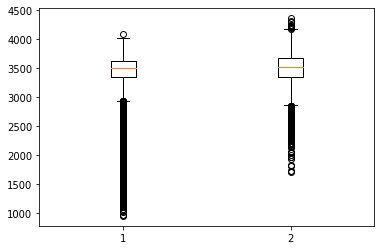

In [33]:
# Reconstruction error box plot
plt.boxplot(recon_error)
plt.show()

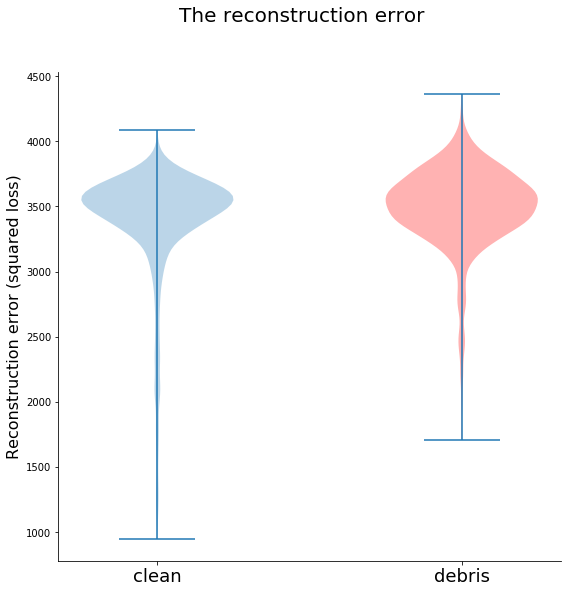

In [51]:
# Sa,e with violin plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9), sharey=True)
violin_parts = ax.violinplot(recon_error)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.suptitle('The reconstruction error', fontsize=20)
plt.ylabel('Reconstruction error (squared loss)', fontsize=16)
violin_parts['bodies'][1].set_facecolor('red')
plt.xticks([1,2])
ax.set_xticklabels(['clean', 'debris'],{'fontsize': 18})
plt.show()

In [42]:
# Ideas
# Group names
[['clean','debris'],['latent','loss']]
# Violin plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9), sharey=True)
ax.violinplot(latent_mean)
# Ranksum test results
ranksums(latent_mean[0],latent_mean[1])

SyntaxError: invalid syntax (<ipython-input-42-80dc433c4b02>, line 11)

In [142]:
latent_forLR = OrderedDict()
latent_forLR['clean'] = torch.cat((results['clean']['latent']['Mu'],results['clean']['latent']['logvar']), dim=1).numpy()
latent_forLR['debris'] = torch.cat((results['debris']['latent']['Mu'],results['debris']['latent']['logvar']), dim=1).numpy()

In [191]:
# CREATE an array of features and the vector of targets(1: 'clean', 1: 'debris')
num_samples = [l.shape[0] for l in latent_forLR.values()]
target = np.concatenate([np.zeros(num_samples[0],dtype=np.int),np.ones(num_samples[1],dtype=np.int)])
featureMatrix = np.concatenate(list(latent_forLR.values()))
# get train/test split
X_train, X_test, y_train, y_test = train_test_split(featureMatrix, target, test_size=0.15, random_state=42, shuffle=True)
# Standardize
# Scale the features
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [190]:
clf = LogisticRegression(random_state=0, n_jobs=8, penalty='elasticnet', tol=0.01, solver='saga',max_iter=1000).fit(X_train_scaled, y_train)

In [ ]:
# hyperparameter optimization
clf = LogisticRegression(random_state=0, n_jobs=8, penalty='elasticnet', tol=0.01, solver='saga',max_iter=1000)
parameter_space = {'C': loguniform(1e0, 1e3),'l1_ratio': stats.uniform(0, 1)}
scoring = {'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)}
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=parameter_space,
                                   n_iter=n_iter_search,scoring=scoring, refit='precision')
start = time()
random_search.fit(X_train_scaled, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))


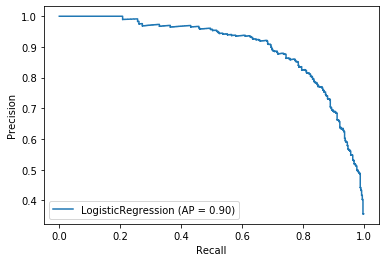

In [206]:
y_prediction = clf.predict(X_test_scaled)
plot_precision_recall_curve(clf, X_test_scaled, y_test)
plt.show()

metrics = precision_recall_fscore_support(y_test,y_prediction)